## 使用ImageNet预训练模型权重

Keras框架提供了预置好的VGG16模型，并提供使用ImageNet进行大规模训练的权重。我们使用预置的VGG16模型，加载预训练的权重，保留VGG16的卷积网络结构，只在最后的全连接层进行调整，使用GlobalAveragePooling2D将7x7x512的卷积结果进行全局池化，减少训练参数，并加入softmax激活、output shape为2的全连接层进行二分类。

首先，我们准备数据：

In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()
    
    if session.region_name == 'cn-north-1':
        bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz"
    elif session.region_name == 'cn-north-4':
        bucket_path="modelarts-labs-bj4/notebook/DL_image_recognition/image_recognition.tar.gz"
    else:
        print("请更换地区到北京一或北京四")

    session.download_data(
    bucket_path=bucket_path,
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: keras_applications==1.0.6 in /opt/anaconda/envs/mask-rcnn/lib/python3.6/site-packages (1.0.6)
Requirement already up-to-date: keras==2.2.4 in /opt/anaconda/envs/mask-rcnn/lib/python3.6/site-packages (2.2.4)


### 导入相关库

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### 准备数据集

In [3]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [4]:
(x_train, y_train) = load_data()

In [5]:
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [6]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [24]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [8]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


### 准备模型

我们定义输入数据的维度，并构建VGG16模型，加载ImageNet预训练的权重（如果预训练权重不存在，则从网络下载，并保存到到$HOME目录的.keras/models/路径下）。include_top=False表示只取卷积网络结构中的参数，不包含全连接层和softmax分类层（ImageNet有1000个分类）。

In [9]:
base_model = VGG16(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


我们把所有卷基层的trainable设置为False，不进行训练。然后将池化层和全连接的二分类层添加到模型中，输入层不变

In [10]:
for layer in base_model.layers:
    layer.trainable = False

model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

可以看到，训练的参数个数为1026，我们仅训练分类部分。

### 设置模型的损失函数和优化器

In [11]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### 设置callback并训练模型

使用预训练的权重，可以较快提高模型精度。在高性能GPU环境下，每一轮需要几分钟左右，请实践者保持耐心，笔者的实践中训练到第11轮就达到了约90%的精度，耗时约8分钟。

后续训练精度提升开始变慢，在41轮达到约92%的精度，耗时约30分钟。

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=15, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./ckpt_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=10, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [13]:
history = model.fit(x=x_train, 
                    y=y_train, 
                    batch_size=16, 
                    epochs=100, 
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_split=0.25, 
                    shuffle=True, 
                    initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Train on 18750 samples, validate on 6250 samples
Epoch 1/100
18750/18750 [==============================] - 48s 3ms/step - loss: 0.6284 - acc: 0.6794 - val_loss: 0.5503 - val_acc: 0.7995

Epoch 00001: val_acc improved from -inf to 0.79952, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 2/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.4959 - acc: 0.8314 - val_loss: 0.4565 - val_acc: 0.8410

Epoch 00002: val_acc improved from 0.79952 to 0.84096, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 3/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.4233 - acc: 0.8564 - val_loss: 0.4012 - val_acc: 0.8630

Epoch 00003: val_acc improved from 0.84096 to 0.86304, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 4/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.3789 - acc: 0.8707 - val_loss: 0.3669 - val_acc: 0.8710

Epoch 00004: val_acc improved from 0.86304 to 0.87104

18750/18750 [==============================] - 44s 2ms/step - loss: 0.2057 - acc: 0.9198 - val_loss: 0.2122 - val_acc: 0.9176

Epoch 00036: val_acc improved from 0.91728 to 0.91760, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 37/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.2047 - acc: 0.9196 - val_loss: 0.2114 - val_acc: 0.9187

Epoch 00037: val_acc improved from 0.91760 to 0.91872, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 38/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.2038 - acc: 0.9199 - val_loss: 0.2103 - val_acc: 0.9182

Epoch 00038: val_acc did not improve from 0.91872
Epoch 39/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.2027 - acc: 0.9206 - val_loss: 0.2096 - val_acc: 0.9189

Epoch 00039: val_acc improved from 0.91872 to 0.91888, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 40/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.2019 - acc: 0.9204 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18750/18750 [==============================] - 44s 2ms/step - loss: 0.1882 - acc: 0.9254 - val_loss: 0.1966 - val_acc: 0.9210

Epoch 00063: val_acc did not improve from 0.92208
Epoch 64/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1876 - acc: 0.9256 - val_loss: 0.1963 - val_acc: 0.9210

Epoch 00064: val_acc did not improve from 0.92208
Epoch 65/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1873 - acc: 0.9251 - val_loss: 0.1968 - val_acc: 0.9230

Epoch 00065: val_acc improved from 0.92208 to 0.92304, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 66/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1870 - acc: 0.9254 - val_loss: 0.1958 - val_acc: 0.9205

Epoch 00066: val_acc did not improve from 0.92304
Epoch 67/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1866 - acc: 0.9256 - val_loss: 0.1953 - val_acc: 0.9214

Epoch 00067: val_acc did not improve from 0.92304
Epoch 68/100
1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18750/18750 [==============================] - 44s 2ms/step - loss: 0.1779 - acc: 0.9288 - val_loss: 0.1884 - val_acc: 0.9232

Epoch 00098: val_acc did not improve from 0.92464
Epoch 99/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1776 - acc: 0.9291 - val_loss: 0.1882 - val_acc: 0.9237

Epoch 00099: val_acc did not improve from 0.92464
Epoch 100/100
18750/18750 [==============================] - 44s 2ms/step - loss: 0.1774 - acc: 0.9292 - val_loss: 0.1880 - val_acc: 0.9243

Epoch 00100: val_acc did not improve from 0.92464


0.7995200000190735


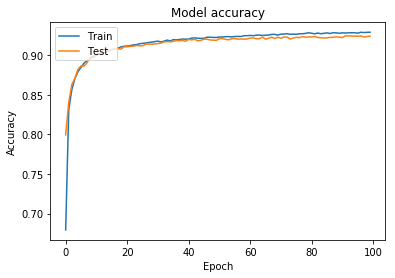

In [21]:
import matplotlib.pyplot as plt
print(history.history['val_acc'][0])
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

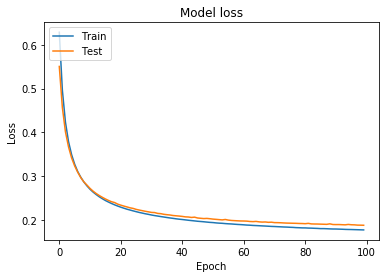

In [22]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

在上面的训练中，我们使用预训练模型的权重，并保留了卷积网络结构中的参数权重，只训练分类层的参数。可以看到，由于预训练模型已经具备了比较好的特征提取能力，初始时就能获得比较高的准确率。

接下来，我们将卷积网络中的参数也一起加入训练。在预训练模型的特征提取能力的基础上开始训练，找到更适合猫狗二分类任务的参数权重：

In [31]:
base_model = VGG16(weights='imagenet', include_top=False)
model = build_model(base_model)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

可以看到，这次模型的Non-trainable params个数为0，所有参数都参与训练，相当于我们使用预训练的参数权重初始化了卷积部分。

### 训练所有参数

直接在预训练权重的基础上进行训练，可以更快的让泛化性较好的权重收敛到适合猫狗二分类的权重，我们仅训练3轮就达到了约95%的精度，耗时约5分钟。

In [32]:
history = model.fit(x=x_train, 
                    y=y_train, 
                    batch_size=16, 
                    epochs=5, 
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_split=0.25, 
                    shuffle=True, 
                    initial_epoch=0)

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 103s 5ms/step - loss: 0.4086 - acc: 0.8029 - val_loss: 0.2317 - val_acc: 0.8989

Epoch 00001: val_acc did not improve from 0.95120
Epoch 2/5
18750/18750 [==============================] - 102s 5ms/step - loss: 0.2157 - acc: 0.9247 - val_loss: 0.2462 - val_acc: 0.9019

Epoch 00002: val_acc did not improve from 0.95120
Epoch 3/5
18750/18750 [==============================] - 101s 5ms/step - loss: 0.1959 - acc: 0.9379 - val_loss: 0.1228 - val_acc: 0.9555

Epoch 00003: val_acc improved from 0.95120 to 0.95552, saving model to ./ckpt_vgg16_dog_and_cat.h5
Epoch 4/5
18750/18750 [==============================] - 101s 5ms/step - loss: 0.1849 - acc: 0.9386 - val_loss: 0.3406 - val_acc: 0.9373

Epoch 00004: val_acc did not improve from 0.95552
Epoch 5/5
18750/18750 [==============================] - 101s 5ms/step - loss: 0.2295 - acc: 0.9324 - val_loss: 0.1599 - val_acc: 0.9496

Epoch 00005:

0.8988799999618531


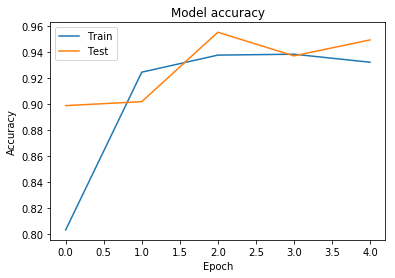

In [33]:
import matplotlib.pyplot as plt
print(history.history['val_acc'][0])
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

可以看到，模型在开始训练后就得到了较高的精度。在VGG论文中，作者也提到了使用预训练好的浅层VGG模型去初始化深层VGG模型的一部分层，再继续训练的技巧。在上面的实践中，我们使用了泛化性更强的参数权重初始化模型，并针对我们特定的任务进行训练，可以更快的得到较好的精度。

### 扩展

尝试使用更深层的网络，如VGG19, ResNet在ImageNet数据集预训练的权重，并针对猫狗二分类任务进行迁移学习，查看模型训练的效果。